## Import

In [1]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

import PIL.ImageOps
import requests
from PIL import Image

In [2]:
transform  = transforms.Compose([transforms.Resize((28,28)),
                                 transforms.ToTensor()
                                ])
training_dataset = datasets.MNIST(root='./mnist', train=True, 
                                  download=True, transform= transform)
validation_dataset = datasets.MNIST(root='./mnist', train=False, 
                                  download=True, transform= transform) 

print ("length of training_dataset: ", len(training_dataset))
print ("length of validation_dataset: ", len(validation_dataset))

length of training_dataset:  60000
length of validation_dataset:  10000


## LeNet Model

In [3]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels= 6, kernel_size=5)
      self.conv2 = nn.Conv2d(6, 16, 5)
      self.fc1 = nn.Linear(4*4*16, 120)
      self.fc2 = nn.Linear(120, 84)
      self.output = nn.Linear(84, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*16)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.output(x)
      return x

## Define our model

In [4]:
model = LeNet()
print (model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, 
                                              batch_size=100,
                                              shuffle=True)
   
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                              batch_size=100,
                                              shuffle=True)

## Training in Action

In [6]:
# Cross Entropy Loss with Adam Optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

epochs = 3

for e in range(epochs):

    train_corrects = 0.0 
    train_batch_loss = 0.0
    train_epoch_loss = 0.0
    val_corrects = 0.0
    val_epoch_loss = 0.0
    
    # loop through 60000 samples 100 at a time
    for batch_idx, data in enumerate(training_loader, start=1):
        inputs = data[0]
        labels = data[1]
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Return the index of the highest possibility
        # which are the predicted labels
        _, preds = torch.max(outputs, 1)
        train_batch_loss += loss.item()

        # sum up all the correct prediction
        # since (preds==labels).sum() is a tensor
        # we use item() to extract the number
        train_corrects += (preds == labels).sum().item()

        # print training loss every 100 mini-batch
        # train_batch_loss is the average loss for 100 mini-batch
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                   e + 1 , 
                   batch_idx * len(data[0]), 
                   len(training_loader.dataset),
                   100.* batch_idx * len(data[0]) / len(training_loader.dataset), 
                   train_batch_loss / 100 ))
            # accumulate loss for the epoch
            train_epoch_loss += train_batch_loss
            # reset the loss for every mini-batch
            train_batch_loss = 0.0
    else:
        # torch.no_grad deactivate the auograd engine, 
        # reduce memory usage and speed up computations
        with torch.no_grad():
            for val_data in validation_loader:
                val_inputs = val_data[0]
                val_labels = val_data[1]
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_epoch_loss += val_loss.item()
                val_corrects += (val_preds == val_labels).sum().item()


        # print result for every epoch 
        train_accuracy = 100. * train_corrects / len(training_loader.dataset)
        # here batch_idx is the total number of mini-batch = 600
        train_epoch_loss /= batch_idx

        print('epoch :', (e+1))
        print('Train set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.6f}'.format(
                train_corrects, len(training_loader.dataset),
                train_accuracy, train_epoch_loss))


        
        val_accuracy = 100. * val_corrects / len(validation_loader.dataset)
        val_epoch_loss /= batch_idx

        print('Validation set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.6f}'.format(
                val_corrects, len(validation_loader.dataset),
                val_accuracy, val_epoch_loss))

Train Epoch: 1 [10000/60000 (17%)] Loss: 0.517122
Train Epoch: 1 [20000/60000 (33%)] Loss: 0.131677
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.119444
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.106806
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.092186
Train Epoch: 1 [60000/60000 (100%)] Loss: 0.088072
epoch : 1
Train set: Accuracy: 56737.0/60000 (95%), Average Loss: 0.175884
Validation set: Accuracy: 9666.0/10000 (97%), Average Loss: 0.018122
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.064115
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.073565
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.065498
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.073791
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.071185
Train Epoch: 2 [60000/60000 (100%)] Loss: 0.066775
epoch : 2
Train set: Accuracy: 58757.0/60000 (98%), Average Loss: 0.069155
Validation set: Accuracy: 9827.0/10000 (98%), Average Loss: 0.011335
Train Epoch: 3 [10000/60000 (17%)] Loss: 0.069367
Train Epoch: 3 [20000/60000 (33%)] Loss: 0.067391
Train Epoc

## Visualize Validation Set Prediciton vs. Ground Truth

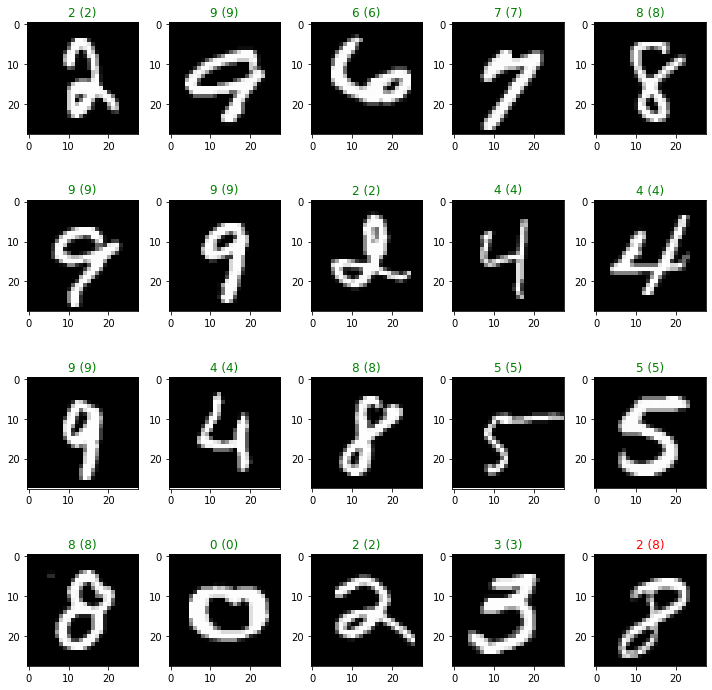

In [9]:
# Visualize predicted labels Vs. ground truth
dataiter = iter(validation_loader)

# Get one batch (100 samples) from validation dataset
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(10, 10))

# Print the first 20 images
for idx in range(1, 21):
    ax = fig.add_subplot(4, 5, idx)
    plt.title("{} ({})".format(str(preds[idx].item()), 
                              str(labels[idx].item())), 
                        color=("green" if preds[idx]==labels[idx] else "red"))
    plt.imshow(transforms.ToPILImage()(images[idx]), cmap='gray')
plt.tight_layout()
plt.show()

## Predict Images from the Web

our predicted result is  3


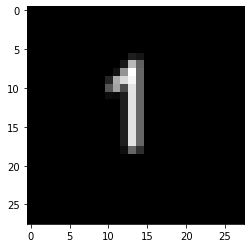

In [8]:
# Test on data from online
url = 'https://upload.wikimedia.org/wikipedia/commons/c/c5/Number-One.JPG'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

# invert the back and white part 
# so it matches with our training data
img = PIL.ImageOps.invert(img)

# convert image to grey-scaled. 
# so the color channel would be 1 
img = img.convert('L')
img = transform(img) 
plt.imshow(transforms.ToPILImage()(img), cmap='gray')


output = model(img.unsqueeze(0))
_, pred = torch.max(output, 1)
print("our predicted result is ", pred.item())